- System 29 from the VADER data set
- 6 months of data

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from sys import path
path.append('..')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
from statistical_clear_sky.utilities.data_conversion import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
from time import time
from datetime import datetime
from os.path import expanduser
ti = time()
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TAEAC1031314')
        and meas_name = 'ac_power'
        and ts <= '2016-01-15';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)
df = make_time_series(df, return_keys=False).fillna(0)
df = df['ac_power_02']
days = df.resample('D').max().index[1:-1]
start = days[0].strftime('%m/%d/%y')
end = days[-1].strftime('%m/%d/%y')
tf = time()
print(start, end)
print('data loading took {:.2f} seconds'.format(tf-ti))

06/26/15 01/13/16
data loading took 2.34 seconds


In [4]:
import cvxpy as cvx

In [5]:
p = df.loc[start:end].values
power_signals_d = df.loc[start:end].values.reshape(288, -1, order='F')[:, :365//2]

In [6]:
power_signals_d.shape

(288, 182)

In [7]:
from statistical_clear_sky.solver_type import SolverType
iterative_fitting = IterativeFitting(power_signals_d, rank_k=6, solver_type=SolverType.mosek)

In [8]:
# The original example code assigns mu_C but mu_C doesn't exist in the source code of IterativeClearSky:
# ics.mu_C = 0.05
iterative_fitting.execute(mu_l=5e2, mu_r=1e3, tau=0.9, max_iteration=14)

obtaining initial value of component r0
obtaining weights
starting at 217066.886 [523.0487622540587, 360.4097099908412, 216183.4272907823, 0]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 329.034 [275.038   7.712  46.284   0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 276.009 [215.053  13.714  47.242   0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 266.212 [200.615  18.167  47.43    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 264.295 [196.587  19.993  47.715   0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 263.780 [195.43   20.592  47.758   0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 263.536 [194.898  20.832  47.806   0.   ]
Minimization complete in 0.40 minutes


(0, 1728)

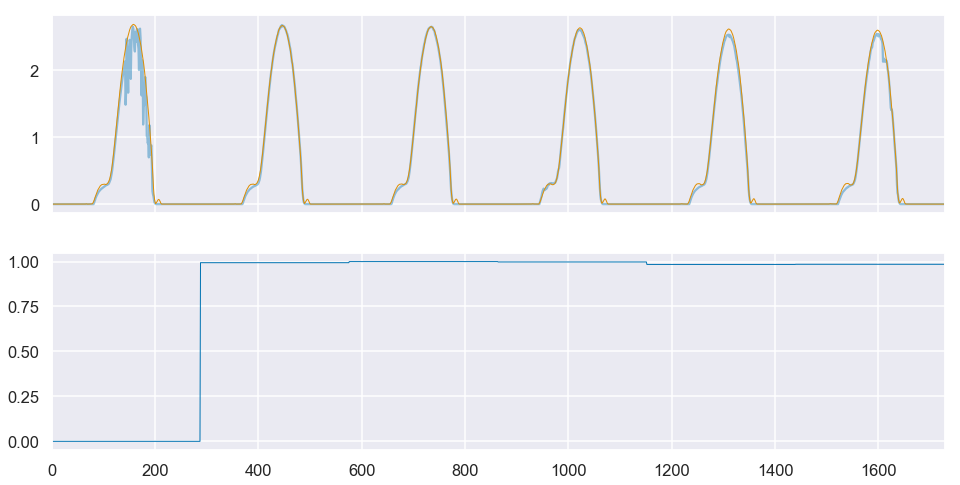

In [9]:
d1 = 170
d2 = d1 + 6
actual = p[d1*288:d2*288]
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(iterative_fitting.weights[d1:d2], 288), linewidth=1)
ax[-1].set_xlim(0, 288*(d2-d1))

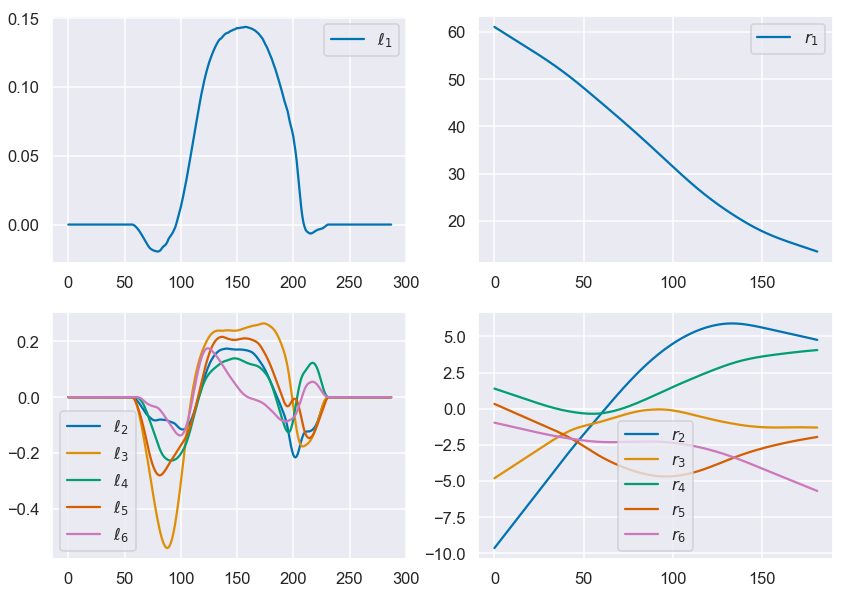

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(iterative_fitting.r_cs_value[0].T)
ax[1, 1].plot(iterative_fitting.r_cs_value[1:].T)
ax[0, 0].plot(iterative_fitting.l_cs_value[:, 0])
ax[1, 0].plot(iterative_fitting.l_cs_value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
plt.show()

[58 49 17 98 64]


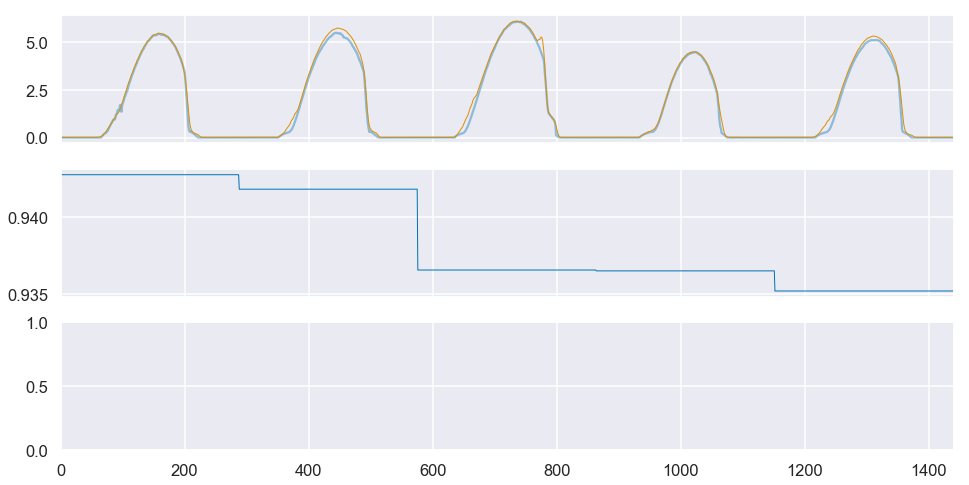

In [11]:
sorted_days = np.argsort(-iterative_fitting.weights)
d1 = 20
d2 = d1 + 5
print(sorted_days[d1:d2])
actual = power_signals_d[:, sorted_days[d1:d2]].ravel(order='F')
clearsky = ((iterative_fitting.clear_sky_signals()))[:, sorted_days[d1:d2]].ravel(order='F')
fig, ax = plt.subplots(nrows=3, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[-1].set_xlim(0, 288*(d2-d1))
ax[1].plot(np.repeat(iterative_fitting.weights[sorted_days[d1:d2]], 288), linewidth=1)
plt.show()

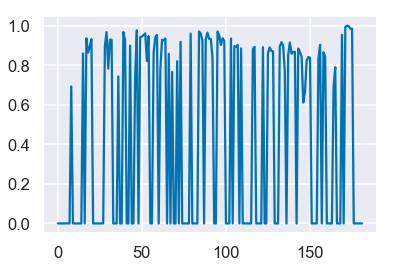

In [12]:
plt.plot(iterative_fitting.weights)

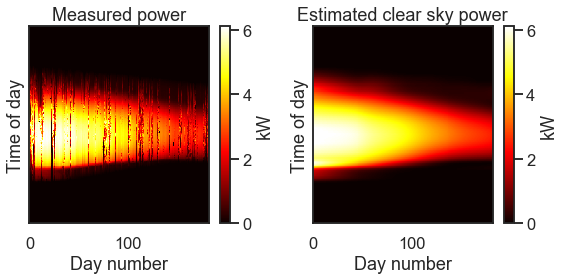

In [13]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(ncols=2, figsize=(8,4))
    foo = ax[0].imshow(power_signals_d, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(iterative_fitting.clear_sky_signals(), cmap='hot', vmin=0, vmax=np.max(power_signals_d), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW')
    plt.colorbar(bar, ax=ax[1], label='kW')
    ax[0].set_xlabel('Day number')
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

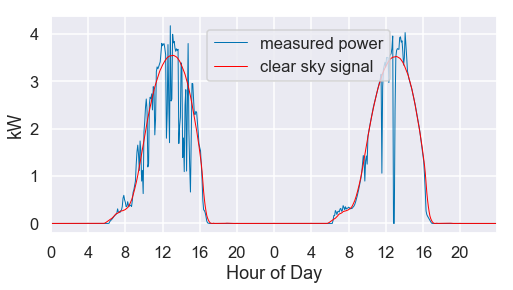

In [14]:
d1 = 130
d2 = d1 + 2
actual = p[d1*288:d2*288]
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(d2-d1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [15]:
print(sum(iterative_fitting.l_cs_value.shape) + sum(iterative_fitting.r_cs_value.shape))

482


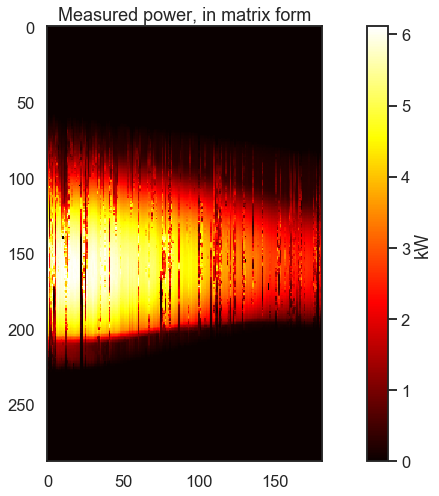

In [16]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(power_signals_d, cmap='hot')
    plt.colorbar(label='kW')
    plt.title('Measured power, in matrix form')

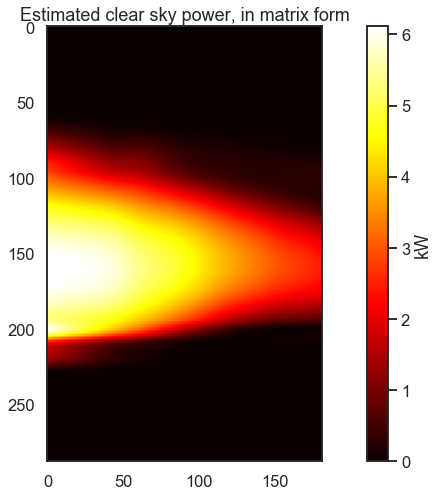

In [17]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(iterative_fitting.clear_sky_signals(), cmap='hot', vmin=0, vmax=np.max(power_signals_d), interpolation='none')
    plt.colorbar(label='kW')
    plt.title('Estimated clear sky power, in matrix form')